In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import pandas as pd
import numpy as np
from scipy.stats import linregress
rcParams['figure.figsize'] = 28, 10
plt.style.use('ggplot')

# Import NY Times Data COVID Data. Source https://github.com/nytimes/covid-19-data
us_counties = "covid_data/us-counties.csv"
us_states = "covid_data/us-states.csv"
us_total = "covid_data/us.csv"
counties = pd.read_csv(us_counties)
states = pd.read_csv(us_states)
us = pd.read_csv(us_total)

us

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
...,...,...,...
173,2020-07-12,3318347,134977
174,2020-07-13,3379859,135402
175,2020-07-14,3445483,136356
176,2020-07-15,3513846,137327


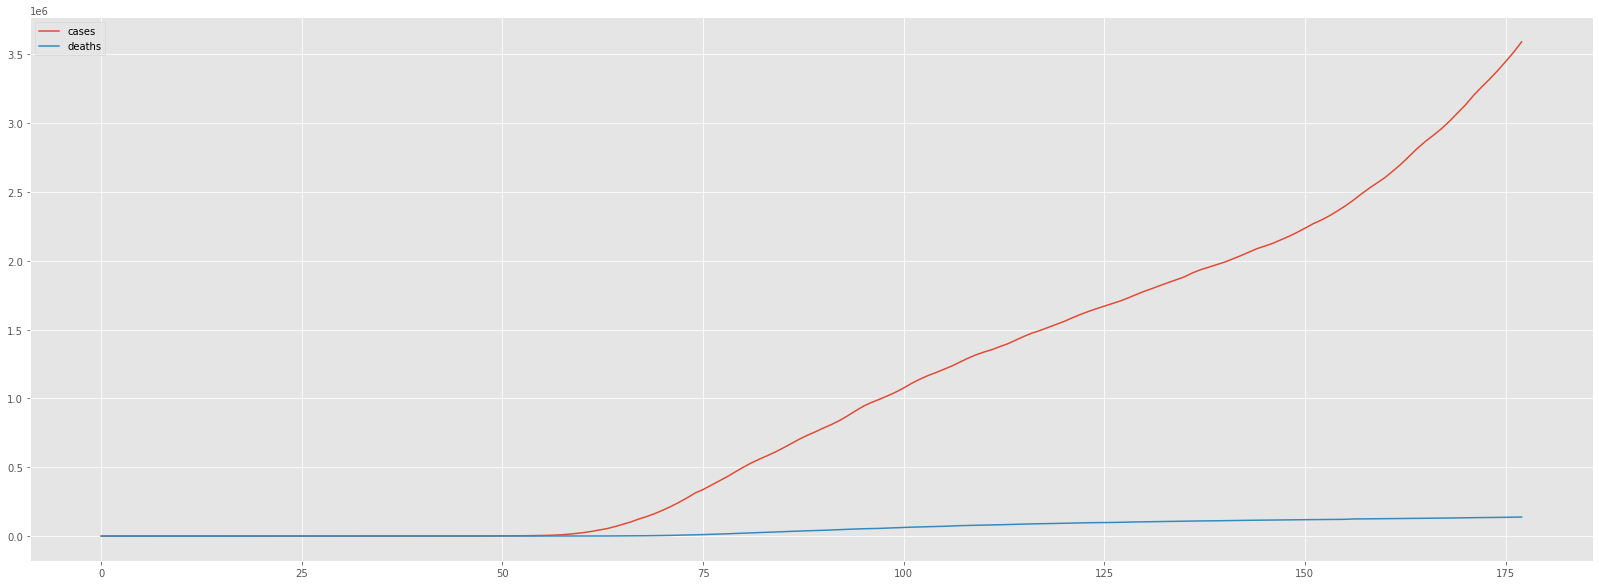

In [2]:
us.plot();
#states[['date','state','cases','deaths']].plot();
#counties.plot();

In [3]:
#Import FiveThirtyEight Presidential Approval Data for Donald Trump https://github.com/fivethirtyeight/data/tree/master/polls

trump_data = "approval_ratings/trump_ratings.csv"
trump_ratings = pd.read_csv(trump_data)
trump_ratings.columns

Index(['president', 'subgroup', 'modeldate', 'startdate', 'enddate',
       'pollster', 'grade', 'samplesize', 'population', 'weight', 'influence',
       'approve', 'disapprove', 'adjusted_approve', 'adjusted_disapprove',
       'multiversions', 'tracking', 'url', 'poll_id', 'question_id',
       'createddate', 'timestamp'],
      dtype='object')

# Analysis of NYT Deaths vs Trump Approval Numbers

In [4]:
# Begin by building a dataframe that contains the date as well as the total deaths from the New York Times data
df_deathapproval = us[['date','deaths']]

# Use the pandas to_datetime function to convert the date from an object to a datetime, to facilitate time-series analysis
df_deathapproval['date_clean'] = pd.to_datetime(df_deathapproval['date'])

In [5]:
# Then compile presidential approval and disapproval data by date

# Use the pandas to_datetime function to convert the date from an object to a datetime, to facilitate time-series analysis

trump_ratings['enddate_clean'] = pd.to_datetime(trump_ratings['enddate'])

# Slice the approval ratings dataframe to remove all polls prior to the beginning of the New York Times dataset
trump_ratings_2020 = trump_ratings.loc[trump_ratings['enddate_clean'] >= '01-21-2020'] 

# Group the approval rating data by date
trump_ratings_2020_grouped = trump_ratings_2020.groupby('enddate_clean')

# Use the group by to calcuate average / overall approval rating across all polls for each date
approval = trump_ratings_2020_grouped['approve'].mean()
disapproval = trump_ratings_2020_grouped['disapprove'].mean()
adj_approval = trump_ratings_2020_grouped['adjusted_approve'].mean()
adj_disapproval = trump_ratings_2020_grouped['adjusted_disapprove'].mean()

#trump_ratings[['startdate','enddate','adjusted_approve']].loc[]

In [6]:
# Convert each individual rating to a dataframe to facilitate merging

approval = pd.DataFrame(approval)
disapproval = pd.DataFrame(disapproval)
adj_approval = pd.DataFrame(adj_approval)
adj_disapproval = pd.DataFrame(adj_disapproval)

# Merge each of the dataframes together to build the dataframe containing Date, Deaths and the various approval / disapproval numbers

deathapproval_approve = pd.merge(df_deathapproval, adj_approval, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean')
deathapproval_adjapprove = pd.merge(deathapproval_approve, adj_disapproval, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean')
deathapproval_adjdisapprove = pd.merge(deathapproval_adjapprove, approval, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean')
df_approvalfinal = pd.merge(deathapproval_adjdisapprove, disapproval, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean')

df_approvalfinal

,date,deaths,date_clean,adjusted_approve,adjusted_disapprove,approve,disapprove
0,2020-01-21,0,2020-01-21,43.076130,52.930799,43.277778,52.722222
1,2020-01-22,0,2020-01-22,41.966678,53.236632,42.769231,53.230769
2,2020-01-23,0,2020-01-23,45.602169,49.896615,46.580000,49.120000
3,2020-01-24,0,2020-01-24,42.208675,54.169452,42.375000,53.000000
4,2020-01-25,0,2020-01-25,41.138551,54.879570,42.000000,54.000000
...,...,...,...,...,...,...,...
173,2020-07-12,134977,2020-07-12,39.979799,56.477837,41.318182,56.045455
174,2020-07-13,135402,2020-07-13,40.762214,55.909417,41.111111,56.111111
175,2020-07-14,136356,2020-07-14,40.948665,54.881739,41.461538,54.153846
176,2020-07-15,137327,2020-07-15,40.921901,54.965856,42.800000,53.800000


In [7]:
# Use variables to hold the data for plotting

x_data = df_approvalfinal['date_clean']
y_data_adjapprove = df_approvalfinal['adjusted_approve']
y_data_approve = df_approvalfinal['approve']
y_data_deaths = df_approvalfinal['deaths']

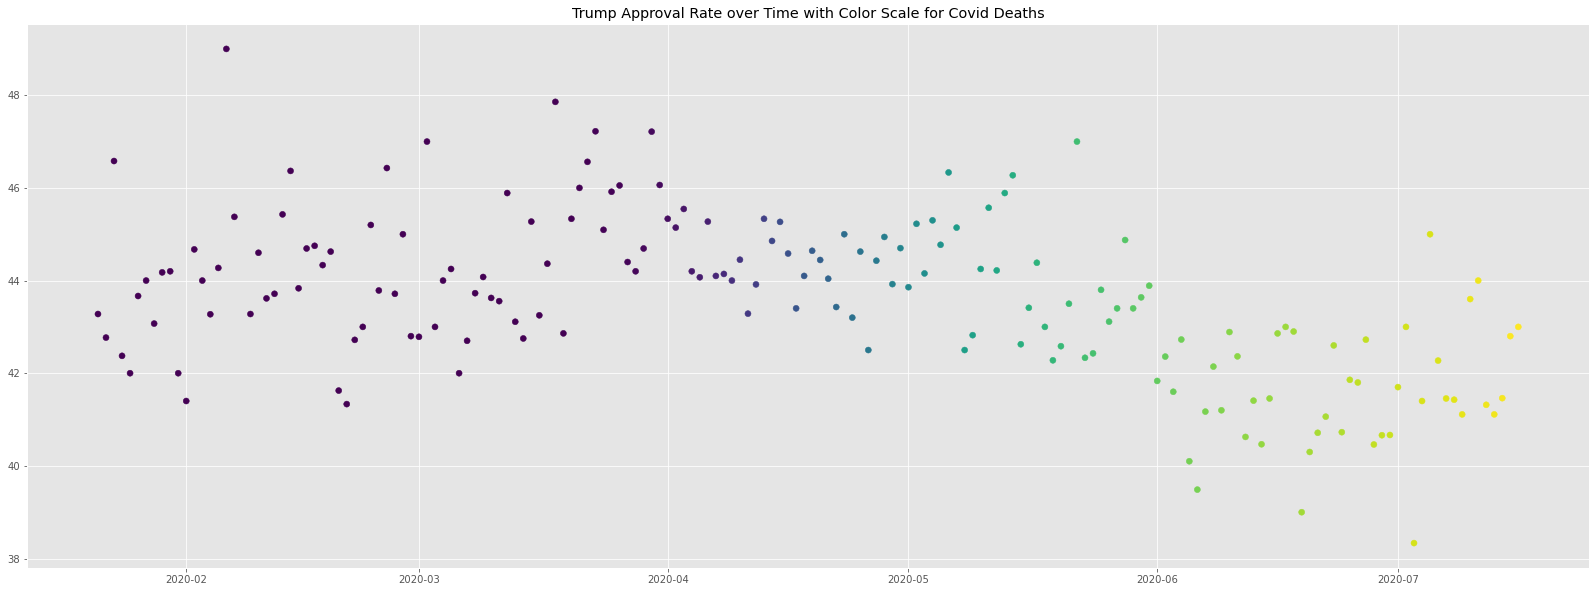

In [8]:
# First attempt at plotting the data.

plt.scatter(x = x_data, y = y_data_approve, c = y_data_deaths)
plt.title('Trump Approval Rate over Time with Color Scale for Covid Deaths');

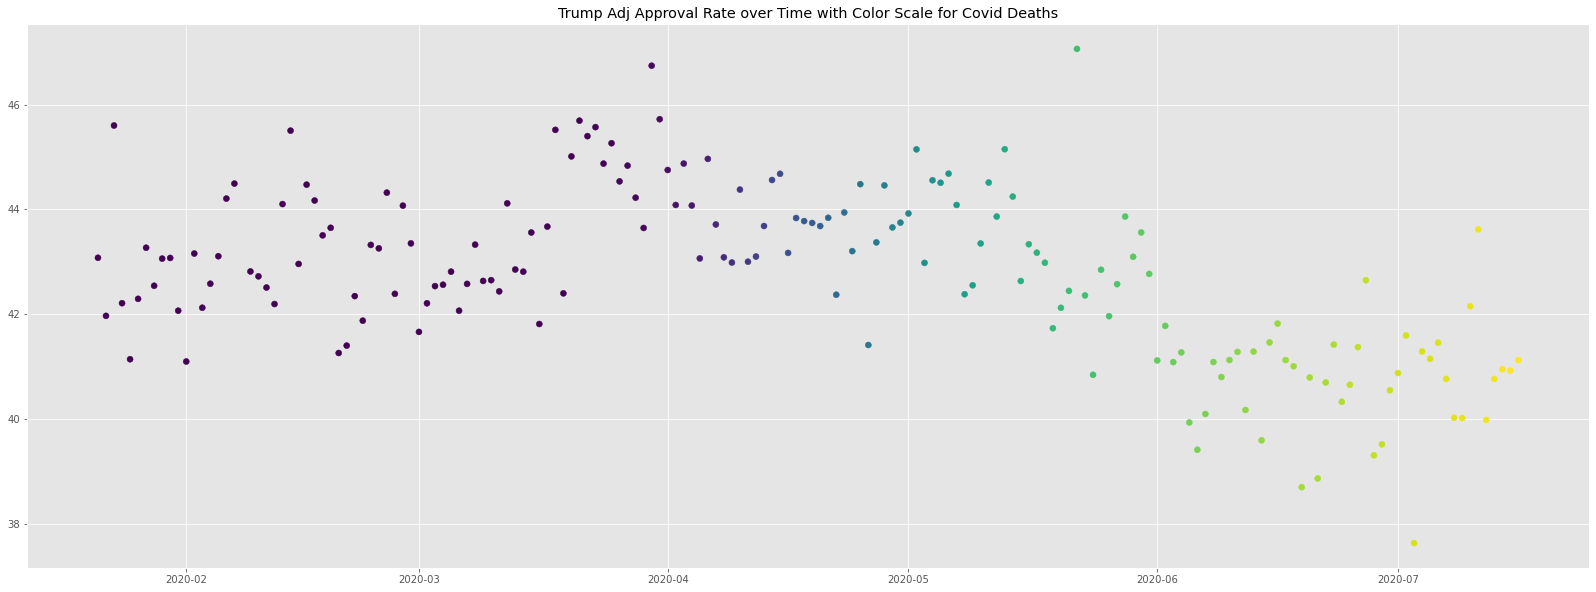

In [10]:
plt.scatter(x = x_data, y = y_data_adjapprove, c = y_data_deaths)
plt.title('Trump Adj Approval Rate over Time with Color Scale for Covid Deaths');

In [13]:
# The above view was difficult to gather conclusions from, lets use a 7-day rolling average to smooth the poll results for better plotting.

# Use the pandas .rolling() method to generate the rolling average adjusted approval rating for each day in the time series
trump_ratings_2020.groupby('enddate_clean').adjusted_approve.rolling(7).mean()

enddate_clean       
2020-01-21     4523    NaN
               4524    NaN
               4528    NaN
               4529    NaN
               4530    NaN
                        ..
2020-07-16     5271    NaN
               5272    NaN
               8554    NaN
               12719   NaN
               12720   NaN
Name: adjusted_approve, Length: 1816, dtype: float64

In [15]:
# Now lets get the rolling adjusted approval and adjusted disapproval for the time series
rolling_approve = pd.DataFrame(trump_ratings_2020_grouped.adjusted_approve.mean().rolling('7d').mean())
rolling_approve

rolling_disapprove = pd.DataFrame(trump_ratings_2020_grouped.adjusted_disapprove.mean().rolling('7d').mean())

# Build a dataframe with the rolling adjusted approval and disapproval numbers

rollers = pd.merge(rolling_approve, rolling_disapprove, how = 'left', on = 'enddate_clean')
rollers

,adjusted_approve,adjusted_disapprove
enddate_clean,,
2020-01-21,43.076130,52.930799
2020-01-22,42.521404,53.083715
2020-01-23,43.548326,52.021349
2020-01-24,43.213413,52.558374
2020-01-25,42.798441,53.022614
...,...,...
2020-07-12,41.142716,55.005278
2020-07-13,41.043789,55.051744
2020-07-14,41.070407,55.020698


In [16]:
# Merge to the rolling data to our existing time-series dataframe with non-rolling numbers. 
df_roll = pd.merge(df_approvalfinal, rollers, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean', suffixes = ('','_roll'))

# Finally lets try to fill in the undecided numbers

df_roll['adjusted_nochoice_roll'] = 100 - df_roll['adjusted_approve_roll'] - df_roll['adjusted_disapprove_roll']
df_roll.to_csv('compare.csv')
df_roll

,date,deaths,date_clean,adjusted_approve,adjusted_disapprove,approve,disapprove,adjusted_approve_roll,adjusted_disapprove_roll,adjusted_nochoice_roll
0,2020-01-21,0,2020-01-21,43.076130,52.930799,43.277778,52.722222,43.076130,52.930799,3.993071
1,2020-01-22,0,2020-01-22,41.966678,53.236632,42.769231,53.230769,42.521404,53.083715,4.394881
2,2020-01-23,0,2020-01-23,45.602169,49.896615,46.580000,49.120000,43.548326,52.021349,4.430326
3,2020-01-24,0,2020-01-24,42.208675,54.169452,42.375000,53.000000,43.213413,52.558374,4.228213
4,2020-01-25,0,2020-01-25,41.138551,54.879570,42.000000,54.000000,42.798441,53.022614,4.178946
...,...,...,...,...,...,...,...,...,...,...
173,2020-07-12,134977,2020-07-12,39.979799,56.477837,41.318182,56.045455,41.142716,55.005278,3.852005
174,2020-07-13,135402,2020-07-13,40.762214,55.909417,41.111111,56.111111,41.043789,55.051744,3.904468
175,2020-07-14,136356,2020-07-14,40.948665,54.881739,41.461538,54.153846,41.070407,55.020698,3.908895
176,2020-07-15,137327,2020-07-15,40.921901,54.965856,42.800000,53.800000,41.199154,54.921322,3.879524


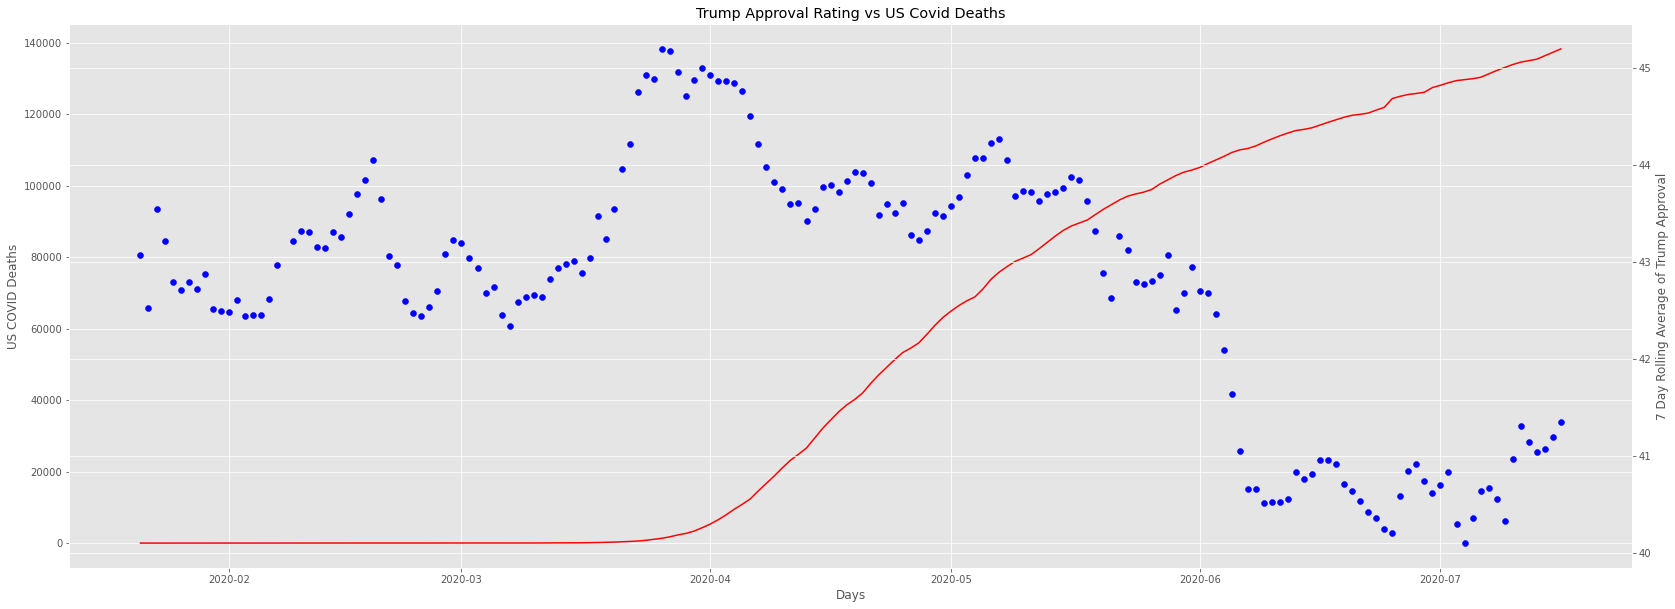

In [17]:
# Collect the data for plotting

x_data = df_roll['date_clean']
y_data_app = df_roll['adjusted_approve_roll']
y_data_dis = df_roll['adjusted_disapprove_roll']
y_data_no = df_roll['adjusted_nochoice_roll']
deaths = df_roll['deaths']


# Build a scatter plot of the approval rating along with a line graph of the aggregate COVID deaths
fig, ax1 = plt.subplots()
ax1.plot(x_data, deaths, color = 'red')
ax1.set_xlabel('Days')
ax1.set_ylabel('US COVID Deaths')

ax2 = ax1.twinx()

ax2.scatter(x = x_data, y = y_data_app, color = 'blue')
ax2.set_ylabel('7 Day Rolling Average of Trump Approval')

plt.title('Trump Approval Rating vs US Covid Deaths')

plt.savefig('Approval_v_Deaths.png');

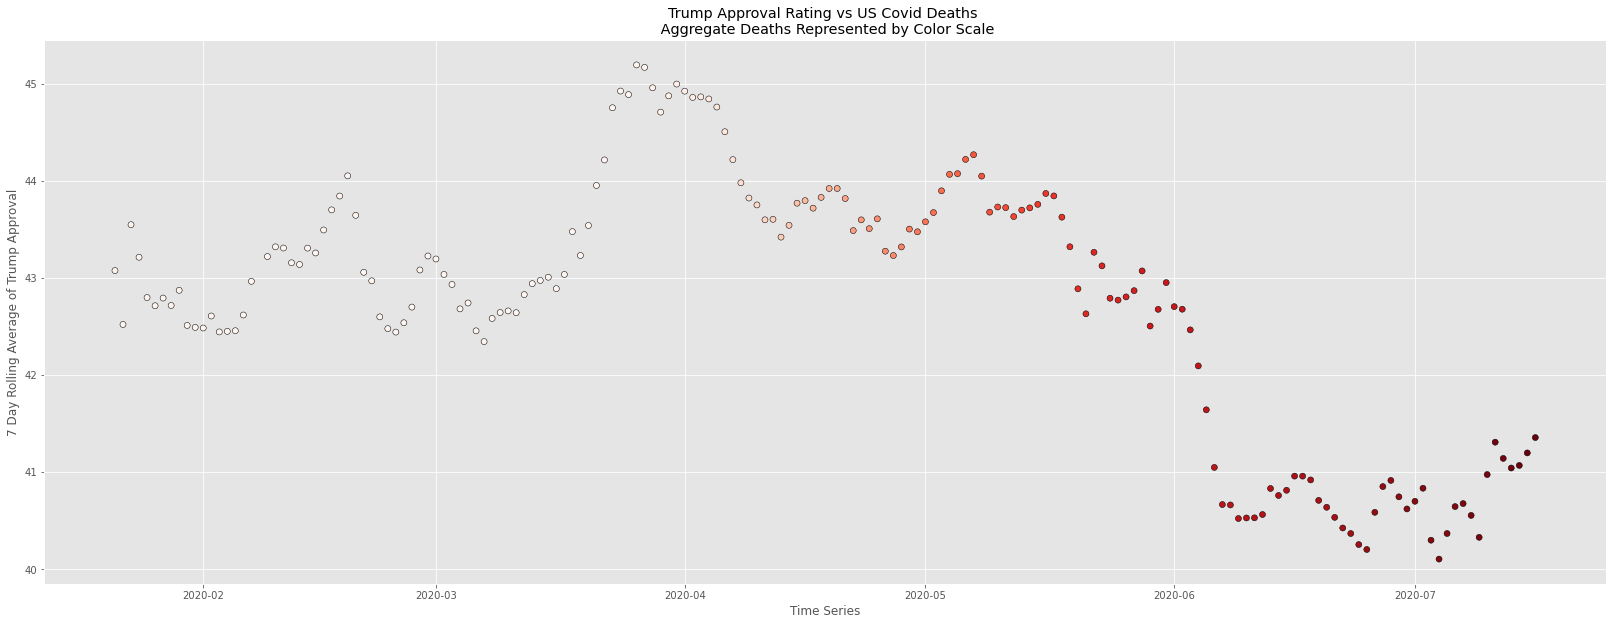

In [18]:
# build a scatter plot to look at the approval / disapproval as the color deaths increase

# We can try to make this cleaner by using a sequential color map, like going in one pallatte from white to dark red, or something.
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

from matplotlib import cm

plt.scatter(x = x_data, y = y_data_app, c = deaths, cmap = 'Reds', edgecolors = 'black')

# Try to overlay the events

plt.title('Trump Approval Rating vs US Covid Deaths \n Aggregate Deaths Represented by Color Scale')

plt.xlabel('Time Series')
plt.ylabel('7 Day Rolling Average of Trump Approval')

plt.savefig('Approval_v_Deaths_ColorScale.png')

plt.show();

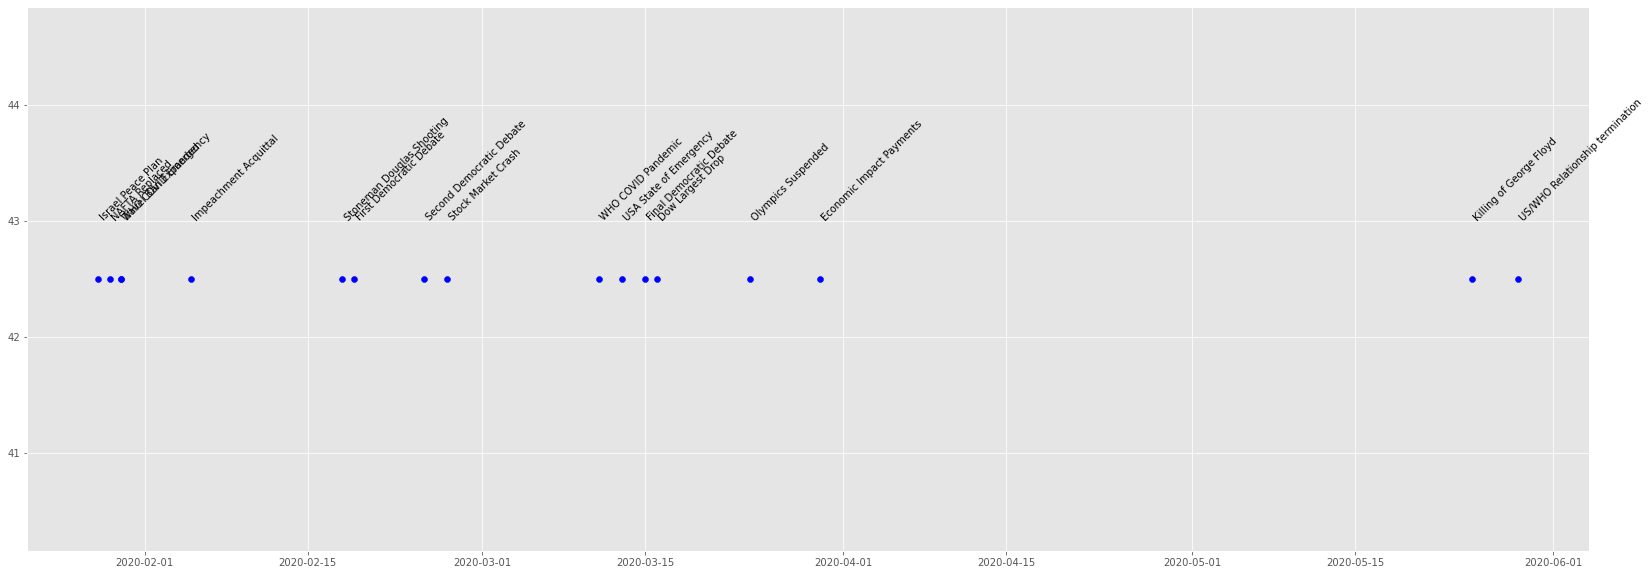

In [22]:
# Construct a timeline of major US National events, data was compiled manually by researching.

#import csv data for Historical Events
Events = "Historical Events_Data Project.csv"
events_df = pd.read_csv(Events, encoding="ISO-8859-1")

# Convert the date using pandas to_datetime

events_df['date_clean'] = pd.to_datetime(events_df['Event date'])

events_2020 = events_df.loc[(events_df['date_clean'] >= '01-21-2020') & (events_df['date_clean'] <= '08-21-2020')]
line = [42.5 for i in range(len(events_2020['date_clean']))]

events_2020

# Lopo through the 2020 events, creating a single notated scatter for each event.
for index, row in events_2020.iterrows():
    plt.scatter(row['date_clean'], 42.5, color = 'blue')
    plt.text(row['date_clean'], 43, row['Event'], rotation = 45)

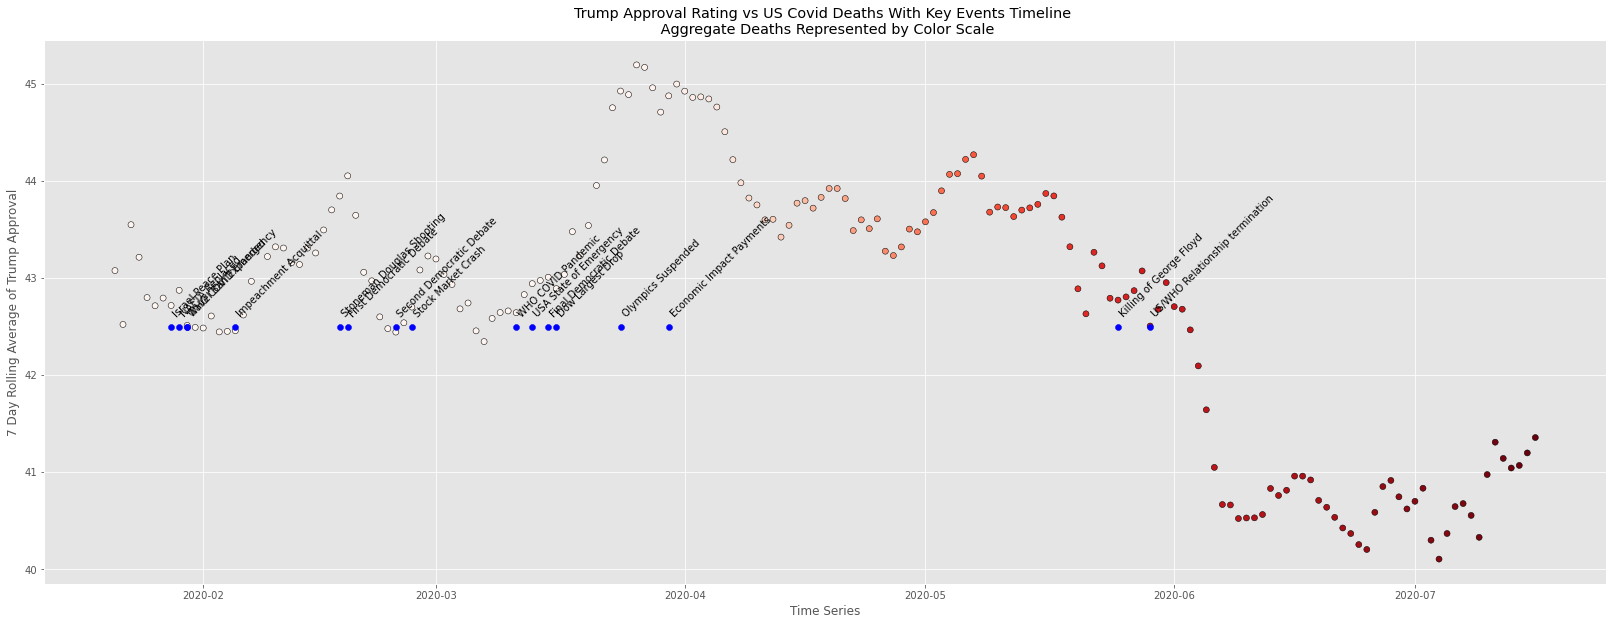

In [23]:
# build a scatter plot to look at the approval / disapproval as the color deaths increase
x_data = df_roll['date_clean']
y_data_app = df_roll['adjusted_approve_roll']
y_data_dis = df_roll['adjusted_disapprove_roll']
y_data_no = df_roll['adjusted_nochoice_roll']
deaths = df_roll['deaths']

# We can try to make this cleaner by using a sequential color map, like going in one pallatte from white to dark red, or something.
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

from matplotlib import cm

plt.scatter(x = x_data, y = y_data_app, c = deaths, cmap = 'Reds', edgecolors = 'black')

# Try to overlay the events

plt.title('Trump Approval Rating vs US Covid Deaths With Key Events Timeline \n Aggregate Deaths Represented by Color Scale')

plt.xlabel('Time Series')
plt.ylabel('7 Day Rolling Average of Trump Approval')

for index, row in events_2020.iterrows():
    plt.scatter(row['date_clean'], 42.5, color = 'blue')
    plt.text(row['date_clean'], 42.6, row['Event'], rotation = 45)
    
plt.savefig('Approval_v_Deaths_ColorScale_WithTimeline');